In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
register_matplotlib_converters()

In [2]:
def parser(s):
    return datetime.strptime(s,"%Y-%m-%d")

In [3]:
catfish_sales = pd.read_csv("catfish.csv" , parse_dates = [0] , index_col = 0,squeeze = True , date_parser = parser)

In [4]:
catfish_sales.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Name: Total, dtype: int64

In [5]:
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [6]:
catfish_sales.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Freq: MS, Name: Total, dtype: int64

In [9]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
catfish_sales_lim = catfish_sales[start_date:end_date]
catfish_sales_lim = catfish_sales_lim/1000
catfish_sales_lim.head()

Date
1996-01-01    20.322
1996-02-01    20.613
1996-03-01    22.704
1996-04-01    20.276
1996-05-01    20.669
Freq: MS, Name: Total, dtype: float64

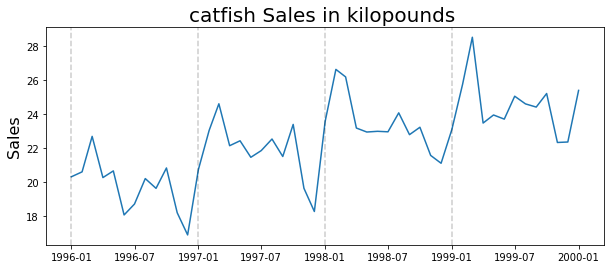

In [11]:
plt.figure(figsize = (10,4))
plt.plot(catfish_sales_lim)
plt.title("catfish Sales in kilopounds " , fontsize = 20)
plt.ylabel('Sales' , fontsize = 16)
for year in range(start_date.year , end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k',linestyle = '--',alpha = 0.2)


In [14]:
first_diff = catfish_sales_lim.diff()[1:]

In [15]:
first_diff.head()

Date
1996-02-01    0.291
1996-03-01    2.091
1996-04-01   -2.428
1996-05-01    0.393
1996-06-01   -2.595
Freq: MS, Name: Total, dtype: float64

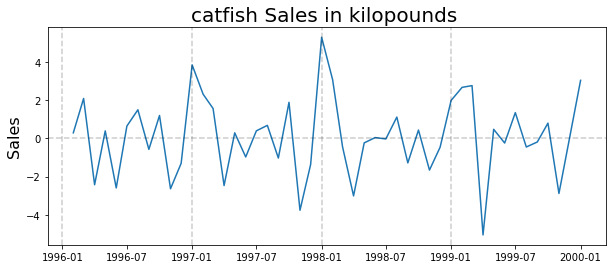

In [16]:
plt.figure(figsize = (10,4))
plt.plot(first_diff)
plt.title("catfish Sales in kilopounds " , fontsize = 20)
plt.ylabel('Sales' , fontsize = 16)
for year in range(start_date.year , end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k',linestyle = '--',alpha = 0.2)
plt.axhline(0,color = 'k' , linestyle = '--' , alpha = 0.2)

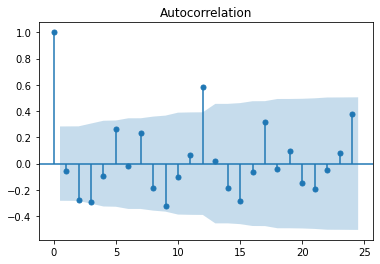

In [20]:
plot_acf(first_diff , lags = 24)
plt.show()

C:\Users\mchun\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


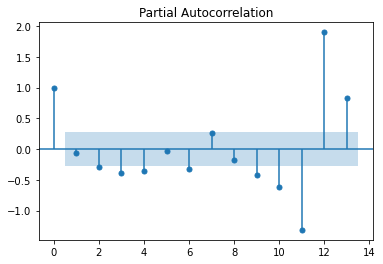

In [21]:
plot_pacf(first_diff , lags = 13)
plt.show()

In [19]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)
train = catfish_sales_lim[:train_end]
test = catfish_sales_lim[train_end + timedelta(days=1):test_end]


<h1>Fit SARIMA MODEL </h1>

In [27]:
my_order = (0,1,0)#(p,d,q)
my_seasonal_order = (1,0,1,12)#(p,d,q,s) s is seasonality
model = SARIMAX(train , order = my_order , seasonal_order = my_seasonal_order)

In [28]:
start = time()
moddel_fit = model.fit(max_iter = 1000)
end = time()
print(f'model fitting time is {end-start}s')

model fitting time is 0.07799839973449707s


C:\Users\mchun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\mchun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [29]:
print(moddel_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -74.595
Date:                              Fri, 31 May 2024   AIC                            155.190
Time:                                      16:00:32   BIC                            160.403
Sample:                                  01-01-1996   HQIC                           157.101
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9348      0.087     10.720      0.000       0.764       1.106
ma.S.L12      -0.42

In [30]:
#predictions and residuals
predictions = moddel_fit.forecast(len(test))
predictions = pd.Series(predictions,index = test.index)
residuals = test-predictions

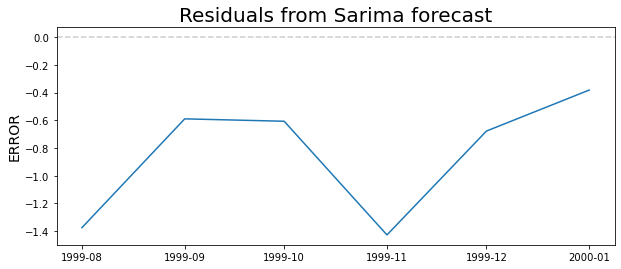

In [31]:
plt.figure(figsize = (10,4))
plt.plot(residuals)
plt.axhline(0,linestyle = '--' , color = 'k' , alpha = 0.2)
plt.title('Residuals from Sarima forecast' , fontsize = 20)
plt.ylabel('ERROR' , fontsize = 14)
plt.show()

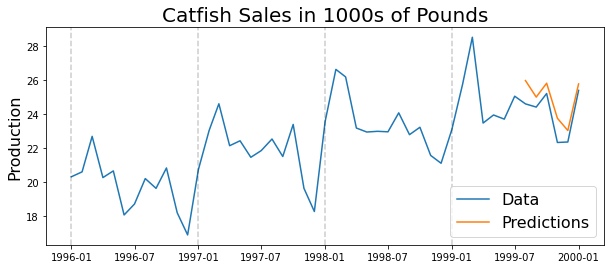

In [33]:
plt.figure(figsize=(10,4))

plt.plot(catfish_sales_lim)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [47]:
print(f'MSE : {round(np.mean(abs(residuals/predictions)),6)}')

print(f'RMSE: {np.sqrt(np.mean(residuals**2))}')

MSE : 0.034014
RMSE: 0.9348640339543628


<p> rolling  forecast</p>

In [40]:
rolling_predictions = test.copy()

In [42]:
for train_end in test.index:
    train_data = catfish_sales_lim[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data,order = my_order,seasonal_order = my_seasonal_order)
    model_fit = model.fit(max_iter = 1000)
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\mchun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\mchun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [44]:
rolling_residuals = test - rolling_predictions

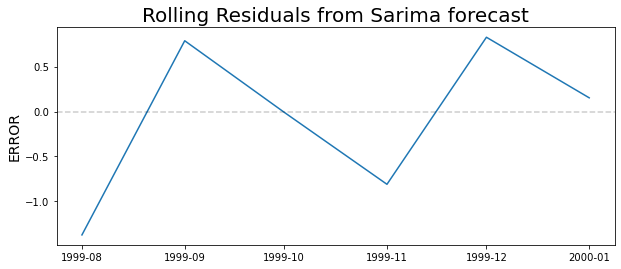

In [45]:
plt.figure(figsize = (10,4))
plt.plot(rolling_residuals)
plt.axhline(0,linestyle = '--' , color = 'k' , alpha = 0.2)
plt.title('Rolling Residuals from Sarima forecast' , fontsize = 20)
plt.ylabel('ERROR' , fontsize = 14)
plt.show()

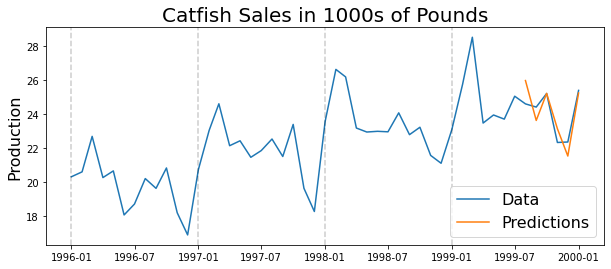

In [46]:
plt.figure(figsize=(10,4))

plt.plot(catfish_sales_lim)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [48]:
print(f'MSE : {round(np.mean(abs(rolling_residuals/rolling_predictions)),6)}')
print(f'RMSE: {np.sqrt(np.mean(rolling_residuals**2))}')

MSE : 0.027664
RMSE: 0.8035979535427407
